In [1]:
# Import Libraries
# !pip install tensorflow-gpu==2.0.0alpha0
import pandas as pd
from PIL import Image

import numpy as np
import random
import os
import os
import cv2
import tensorflow as tf
from tensorflow.keras import losses
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import math
import random
from keras.utils.generic_utils import Progbar
# from keras.backend import image_dim_ordering
from keras.backend import image_data_format
import copy
import matplotlib.pyplot as plt
import hyperparameters

2022-12-14 23:41:50.839047: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yash/Desktop/Courses/CS1430/cv_env/lib/python3.9/site-packages/cv2/../../lib64:
2022-12-14 23:41:50.839066: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load & Preprocess Data

In [2]:
from preprocess import *
from data_load_resize import data_loading_and_resizing
from visualize import visualize_doc

### Load data

In [3]:
data_path = "/home/yash/Desktop/Courses/CS1430/final_project/0_experiments/train_val_test_data/train_data"
training_images, train_bounding_boxes, testing_images, test_bounding_boxes = get_data(data_path)

train_images, train_labels = data_loading_and_resizing(training_images, train_bounding_boxes)
test_images, test_labels = data_loading_and_resizing(testing_images, test_bounding_boxes)

### Visualize data

Train Image Dataset
bounding box [143, 203, 224, 218]
x, y 143 203
width, height 81 15


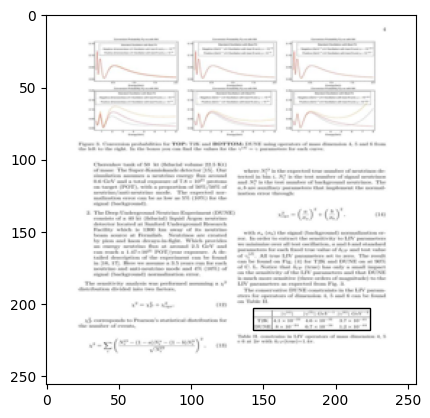

bounding box [70, 23, 185, 95]
x, y 70 23
width, height 115 72


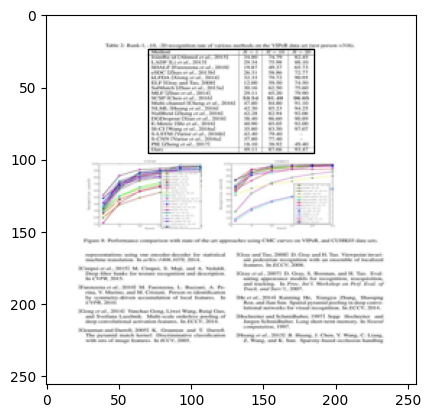

In [4]:
from visualize import visualize_doc
print('Train Image Dataset')
for i in range(len(train_images[:2])):
    visualize_doc(train_images[i], train_labels[i])

In [5]:
# print('Test Image Dataset')

# for i in range(len(test_images[:5])):
#     visualize_doc(test_images[i], test_labels[i])

### Analyze distribution of box widths, heights and h/w ratios to inform anchor box proposal sizes and shapes

In [15]:
train_boxes_df = pd.DataFrame(train_labels, columns=['x_min', 'y_min', 'x_max', 'y_max'])
train_boxes_df['width'] = train_boxes_df['x_max'] - train_boxes_df['x_min']
train_boxes_df['height'] = train_boxes_df['y_max'] - train_boxes_df['y_min']
train_boxes_df['h_w_ratio'] = train_boxes_df['height'] / train_boxes_df['width']
train_boxes_df.head()

,x_min,y_min,x_max,y_max,width,height,h_w_ratio
0,143,203,224,218,81,15,0.185185
1,70,23,185,95,115,72,0.626087
2,16,39,244,100,228,61,0.267544
3,32,30,222,81,190,51,0.268421
4,63,25,176,82,113,57,0.504425


In [21]:
train_boxes_df[['width', 'height', 'h_w_ratio']].describe()

,width,height,h_w_ratio
count,363.000000,363.000000,363.000000
mean,128.421488,49.440771,0.414573
std,48.125599,42.411021,0.366193
min,23.000000,7.000000,0.043956
25%,93.000000,21.500000,0.186522
50%,117.000000,35.000000,0.288889
75%,169.000000,60.000000,0.514234
max,235.000000,210.000000,2.423077


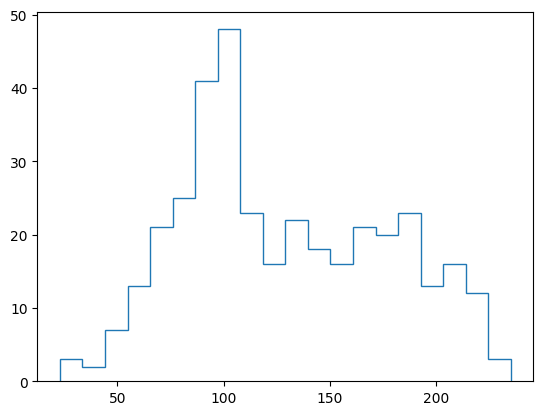

In [18]:
# Widths
counts, bins = np.histogram(train_boxes_df['width'], bins=20)
plt.stairs(counts, bins)

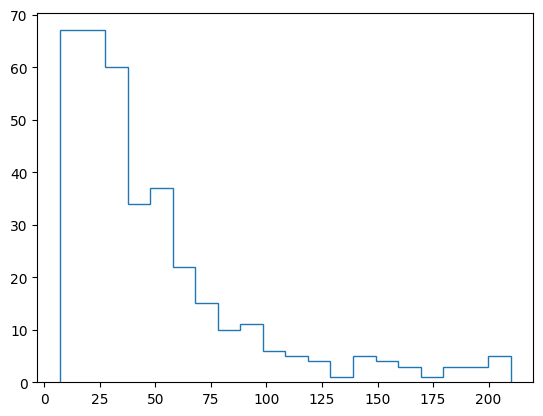

In [19]:
# Widths
counts, bins = np.histogram(train_boxes_df['height'], bins=20)
plt.stairs(counts, bins)

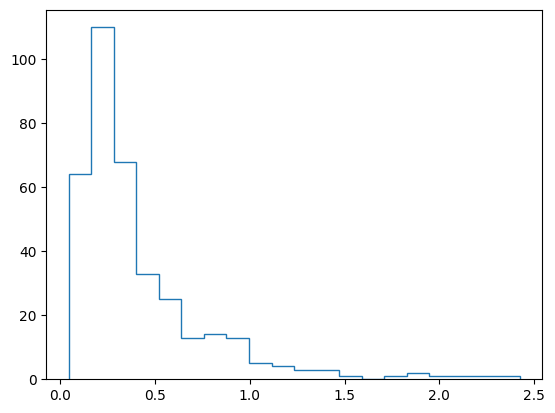

In [20]:
# Ratios
counts, bins = np.histogram(train_boxes_df['h_w_ratio'], bins=20)
plt.stairs(counts, bins)

We note that boxes tend to be wider than they are tall, and that heights and widths are distributed in some fashion that we can leverage to create possible widths and shapes for proposed boxes. See `hyperparameters.py` for proposed sizes and ratios. 

## Import functions required for model training

### Convert labels to format consumable by model for training

In [4]:
from iou import compute_iou
from rpn_features import generate_roi_props, get_anchor_gt
from get_roi_from_rpn import *

### Load model

In [5]:
model_weights_save_path = '/home/yash/Desktop/Courses/CS1430/final_project/0_experiments/model_save_path_2/'

In [6]:
from model_architecture import *
model = ModelConfig(img_w=hyperparameters.image_width , img_h=hyperparameters.image_height, 
                    epochs=10, model_weights_save_path=model_weights_save_path)
# load_weight_path='/home/yash/Desktop/Courses/CS1430/final_project/0_experiments/model_save_path/'
model.rpn_model.summary()

2022-12-14 23:42:10.216935: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yash/Desktop/Courses/CS1430/cv_env/lib/python3.9/site-packages/cv2/../../lib64:
2022-12-14 23:42:10.216967: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-14 23:42:10.216990: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yash-ThinkPad-L390): /proc/driver/nvidia/version does not exist
2022-12-14 23:42:10.217271: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 model (Functional)             (None, 16, 16, 512)  14714688    ['input_2[0][0]']                
                                                                                                  
 conv_rpn (Conv2D)              (None, 16, 16, 512)  2359808     ['model[0][0]']                  
                                                                                                  
 rpn_classify (Conv2D)          (None, 16, 16, 25)   12825       ['conv_rpn[0][0]']         

## Checking stuff

In [7]:
# trial = train_images[0]
# trial.min(), trial.max()
# trial2 = preprocess_input(trial)

# with open('/home/yash/Desktop/Courses/CS1430/final_project/0_experiments/trial.npy', 'rb') as f:
#     X_ = np.load(f, allow_pickle=True)
#     Y0_ = np.load(f, allow_pickle=True)
#     Y1_ = np.load(f, allow_pickle=True)
#     Y_ = [Y0_, Y1_]

## Done with Checking stuff

## Training

In [8]:
examples_in_epoch = len(train_images)
# examples_in_epoch = 5
loss_arr = np.zeros((examples_in_epoch, 2))
loss_cls = []
loss_regr = []

In [9]:
for epoch_num in range(model.epochs):
    model.current_epoch = epoch_num
    print('Current epoch: {}/{}'.format(model.current_epoch + 1, model.epochs))

    data_gen_train = get_anchor_gt(train_images, train_labels)
    record_ix = 0
    epoch_start_time = time.time()
    progress = Progbar(examples_in_epoch)
    while True:
        try:
            # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
            X, Y, labels, index = next(data_gen_train)

            # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
            loss_rpn = model.rpn_model.train_on_batch(X, Y)

            cls_prop, rgr_prop = model.rpn_model.predict_on_batch(X)
            roi_pred = infer_roi_from_rpn(model.anchor_box_scales, model.anchor_box_ratios, cls_prop, rgr_prop, max_boxes=300, overlap_thresh=0.7)
            roi_pred = roi_pred * 16
            pred_labels, acc = match_regions(labels, roi_pred)

            loss_arr[record_ix, 0] = loss_rpn[1]
            loss_arr[record_ix, 1] = loss_rpn[2]

            record_ix += 1

            progress.update(record_ix, [('classif_loss', np.mean(loss_arr[:record_ix, 0])), 
                                        ('regr_loss', np.mean(loss_arr[:record_ix, 1]))])
            
            if record_ix == examples_in_epoch:
                loss_rpn_cls = np.mean(loss_arr[:, 0])
                loss_rpn_regr = np.mean(loss_arr[:, 1])
                loss_cls.append(loss_rpn_cls)
                loss_regr.append(loss_rpn_regr)
                epoch_end_time = time.time()
                model.epoch_times.append(epoch_end_time - epoch_start_time)
                record_ix = 0
                
                print('Loss RPN Classifier: ', loss_rpn_cls)
                print('Loss RPN Regressor: ', loss_rpn_regr)

                # Save model
                model.save_model_weights(loss_cls, loss_regr)

                break

        except Exception as e:
            print('Exception: {}'.format(e))
            continue
        
print("Training complete!")

Current epoch: 1/10
  3/363 [..............................] - ETA: 6:22 - classif_loss: 3.6610 - regr_loss: 1.0653

/home/yash/Desktop/Courses/CS1430/final_project/repo/pdf-table-detector/code/get_roi_from_rpn.py:116: RuntimeWarning: overflow encountered in exp
  adj_w = np.exp(dw.astype(np.float64)) * w0
/home/yash/Desktop/Courses/CS1430/final_project/repo/pdf-table-detector/code/get_roi_from_rpn.py:117: RuntimeWarning: overflow encountered in exp
  adj_h = np.exp(dh.astype(np.float64)) * h0
/home/yash/Desktop/Courses/CS1430/final_project/repo/pdf-table-detector/code/get_roi_from_rpn.py:163: RuntimeWarning: invalid value encountered in add
  roi_proposals[2, :, :, layer_ix] += roi_proposals[0, :, :, layer_ix]
/home/yash/Desktop/Courses/CS1430/final_project/repo/pdf-table-detector/code/get_roi_from_rpn.py:164: RuntimeWarning: invalid value encountered in add
  roi_proposals[3, :, :, layer_ix] += roi_proposals[1, :, :, layer_ix]
/home/yash/Desktop/Courses/CS1430/final_project/repo/pdf-table-detector/code/get_roi_from_rpn.py:117: RuntimeWarning: overflow encountered in multiply
  adj_h = np.exp(dh.ast

130/363 [=========>....................] - ETA: 4:51 - classif_loss: 0.7155 - regr_loss: 29948.2525

## Loss Curves

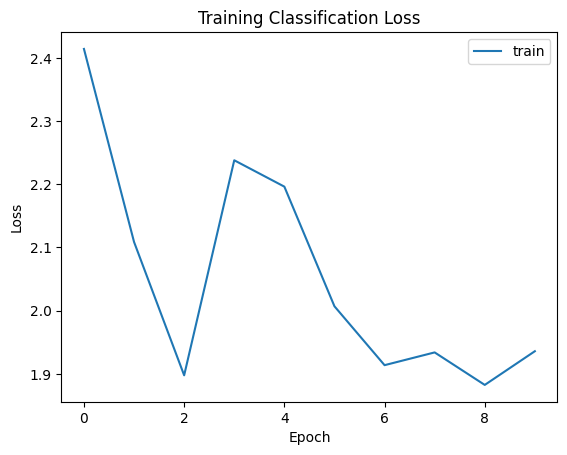

In [24]:
# Classification Loss
plt.plot(loss_cls)   
plt.title('Training Classification Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train']) 
plt.show()

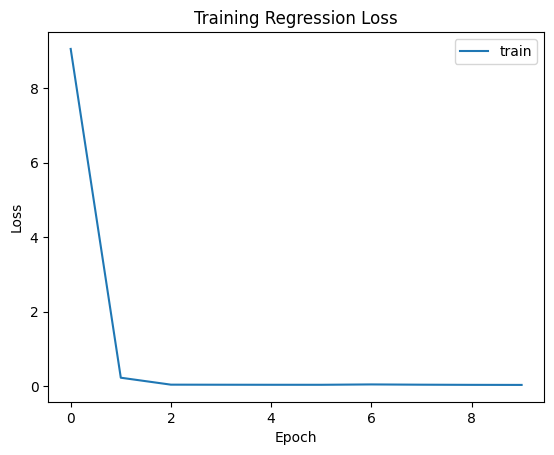

In [25]:
# Regression Loss
plt.plot(loss_regr)   
plt.title('Training Regression Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train']) 
plt.show()

## Accuracy Curves

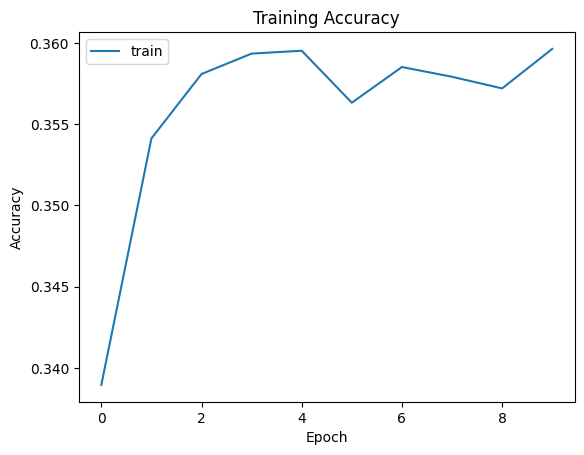

In [26]:
# Regression Loss
plt.plot(accuracy)
plt.title('Training Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train']) 
plt.show()

## Testing

In [23]:
def predict_labels(data_gen):
    X, Y, labels, index = next(data_gen)
    P_rpn = model.rpn_model.predict_on_batch(X)
    roi_pred = infer_roi_from_rpn(model.anchor_box_scales, model.anchor_box_ratios, P_rpn[0], P_rpn[1], max_boxes=300, overlap_thresh=0.7)
    roi_pred = roi_pred * 16
    pred_labels, acc = match_regions(labels, roi_pred)
    return pred_labels, index

def inference(data_gen, images):
    rows = 2
    columns = 3
    fig=plt.figure(figsize=(16, 12))
    for i in range(6):
        fig.add_subplot(rows, columns, i+1, xticks=[], yticks=[])
        labels, index = predict_labels(data_gen)
        image = images[index]
        for label in labels[:1]:
            cv2.rectangle(image,(label[0], label[1]),(label[2],label[3]),(255, 0, 0))
        plt.imshow(image)
    plt.show()

In [24]:
data_gen_train = get_anchor_gt(train_images, train_labels)
data_gen_test = get_anchor_gt(test_images, test_labels)

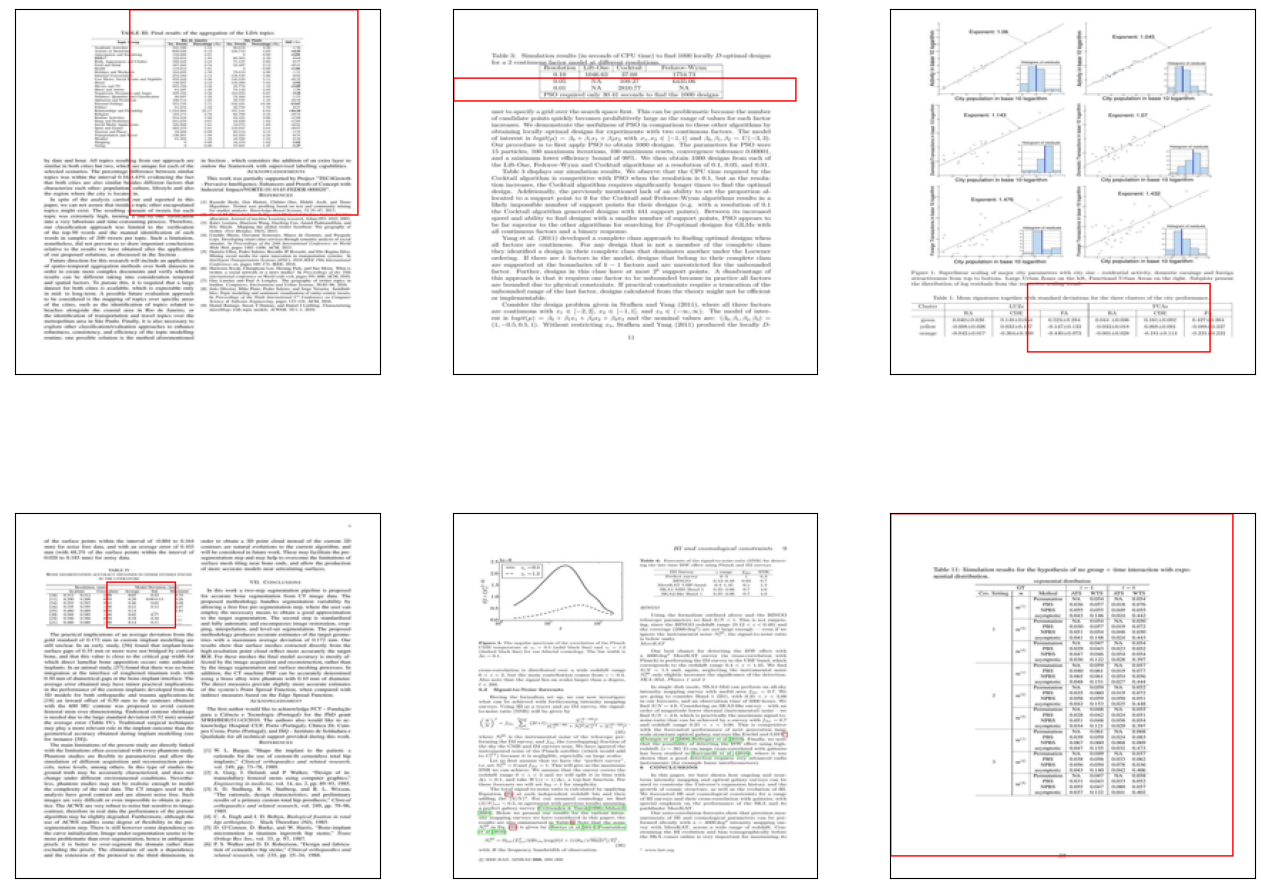

In [25]:
inference(data_gen_train, np.copy(train_images))

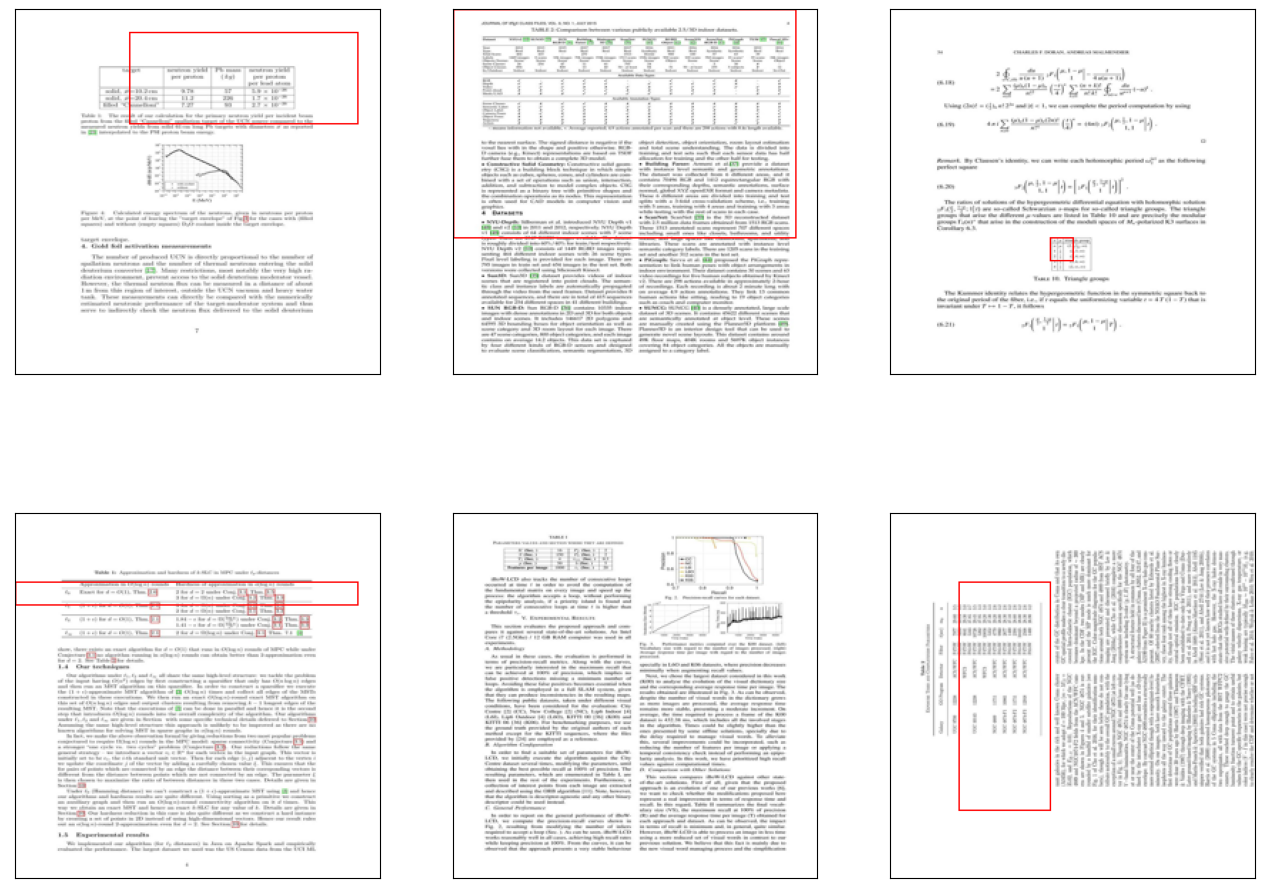

In [26]:
inference(data_gen_test, np.copy(test_images))